# Text Classification TF-IDF Training Parameters (Random Search)

# Import Dataset

In [1]:
import pandas as pd
data_df = pd.read_csv('../Output/Top10_Cancer_1.csv', encoding='utf-8')
data_df = data_df[['Article', 'Clean Article', 'ClassID', 'Class']]
data_df.head(10)

,Article,Clean Article,ClassID,Class
0,Optimal adjuvant therapy in clinically N2 non-...,optimal adjuvant therapy clinically n non smal...,1,lung
1,Assessment of interpatient heterogeneity in tu...,assessment interpatient heterogeneity tumor ra...,1,lung
2,[Current problems in the combined therapy of l...,current problem combine therapy lung cancer pa...,1,lung
3,Effect of therapeutic irradiation on lymphocyt...,effect therapeutic irradiation lymphocyte tran...,1,lung
4,Use of intensive care in patients with nonrese...,use intensive care patient nonresectable lung ...,1,lung
5,Establishment of a drug sensitivity panel usin...,establishment drug sensitivity panel use human...,1,lung
6,Effect of gefitinib re-challenge to initial ge...,effect gefitinib challenge initial gefitinib r...,1,lung
7,[Exposed workers to lung cancer risk. An estim...,expose worker lung cancer risk estimation use ...,1,lung
8,Cytology nomenclature and 2015 World Health Or...,cytology nomenclature world health organizatio...,1,lung
9,[Repeated surgery for lung cancer] -,repeat surgery lung cancer,1,lung


In [2]:
data_labels_map = dict(enumerate(pd.unique(data_df['Class'])))
data_labels_map

{0: 'lung',
 1: 'breast',
 2: 'colorectal',
 3: 'prostate',
 4: 'stomach',
 5: 'liver',
 6: 'oesophagus',
 7: 'cervix_uteri',
 8: 'thyroid',
 9: 'bladder'}

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

train_corpus, test_corpus, train_label_nums, test_label_nums, train_label_names, test_label_names =\
                                 train_test_split(np.array(data_df['Clean Article']), np.array(data_df['ClassID']),
                                                       np.array(data_df['Class']), test_size=0.33, random_state=42)

train_corpus.shape, test_corpus.shape

((6700,), (3300,))

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# build BOW features on train articles
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0)
tv_train_features = tv.fit_transform(train_corpus)
# transform test articles into features
tv_test_features = tv.transform(test_corpus)
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

TFIDF model:> Train features shape: (6700, 49221)  Test features shape: (3300, 49221)


In [39]:
data_labels_map = dict(enumerate(pd.unique(data_df['Class'])))
data_labels_map

{0: 'lung',
 1: 'breast',
 2: 'colorectal',
 3: 'prostate',
 4: 'stomach',
 5: 'liver',
 6: 'oesophagus',
 7: 'cervix_uteri',
 8: 'thyroid',
 9: 'bladder'}

In [40]:
label_data_map = {v:k for k, v in data_labels_map.items()}
label_map_df = pd.DataFrame(list(label_data_map.items()), columns=['Label Name', 'Label Number'])
label_map_df

,Label Name,Label Number
0,lung,0
1,breast,1
2,colorectal,2
3,prostate,3
4,stomach,4
5,liver,5
6,oesophagus,6
7,cervix_uteri,7
8,thyroid,8
9,bladder,9


# Naive Bayes

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

mnb_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('mnb', MultinomialNB())
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'mnb__alpha': [1e-5, 1e-4, 1e-2, 1e-1, 1]
}

gs_mnb = RandomizedSearchCV(mnb_pipeline, param_grid, cv=5, verbose=2,n_jobs=-1)
gs_mnb = gs_mnb.fit(train_corpus, train_label_names)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:   11.6s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.3s finished


In [6]:
gs_mnb.best_estimator_.get_params()

{'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.float64'>, encoding='utf-8',
                   input='content', lowercase=True, max_df=1.0, max_features=None,
                   min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                   smooth_idf=True, stop_words=None, strip_accents=None,
                   sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, use_idf=True, vocabulary=None)),
  ('mnb', MultinomialNB(alpha=1, class_prior=None, fit_prior=True))],
 'verbose': False,
 'tfidf': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='content', lowercase=True, max_df=1.0, max_features=None,
                 min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                 smooth_idf=True, stop_words=None, 

In [7]:
cv_results = gs_mnb.cv_results_
results_df = pd.DataFrame({'rank': cv_results['rank_test_score'],
                           'params': cv_results['params'], 
                           'cv score (mean)': cv_results['mean_test_score'], 
                           'cv score (std)': cv_results['std_test_score']} 
              )
results_df = results_df.sort_values(by=['rank'], ascending=True)
pd.set_option('display.max_colwidth', 100)
results_df

,rank,params,cv score (mean),cv score (std)
9,1,"{'tfidf__ngram_range': (1, 2), 'mnb__alpha': 1}",0.955075,0.004982
7,2,"{'tfidf__ngram_range': (1, 2), 'mnb__alpha': 0.1}",0.935075,0.002628
8,3,"{'tfidf__ngram_range': (1, 1), 'mnb__alpha': 1}",0.923433,0.006601
5,4,"{'tfidf__ngram_range': (1, 2), 'mnb__alpha': 0.01}",0.912836,0.005327
6,5,"{'tfidf__ngram_range': (1, 1), 'mnb__alpha': 0.1}",0.882836,0.005423
3,6,"{'tfidf__ngram_range': (1, 2), 'mnb__alpha': 0.0001}",0.854328,0.006461
4,7,"{'tfidf__ngram_range': (1, 1), 'mnb__alpha': 0.01}",0.838955,0.004823
1,8,"{'tfidf__ngram_range': (1, 2), 'mnb__alpha': 1e-05}",0.834478,0.009677
2,9,"{'tfidf__ngram_range': (1, 1), 'mnb__alpha': 0.0001}",0.769254,0.008923
0,10,"{'tfidf__ngram_range': (1, 1), 'mnb__alpha': 1e-05}",0.751343,0.010237


In [10]:
from sklearn.model_selection import cross_val_score

mnb = MultinomialNB(alpha=1)
mnb.fit(tv_train_features, train_label_names)
gs_mnb_cv_scores = cross_val_score(mnb, tv_train_features, train_label_names, cv=5)
gs_mnb_cv_mean_score = np.mean(gs_mnb_cv_scores)
print('Train Score (5-fold):',gs_mnb_cv_scores)
print('Average Train Score :', gs_mnb_cv_mean_score)

best_mnb_test_score = gs_mnb.score(test_corpus, test_label_names)
print('Test Accuracy :', best_mnb_test_score)

Train Score (5-fold): [0.91940299 0.92537313 0.9141791  0.93059701 0.92313433]
Average Train Score : 0.9225373134328357
Test Accuracy : 0.9518181818181818


In [48]:
import time
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1, 2))
train = tfidf.fit_transform(train_corpus)
mnb = MultinomialNB(alpha=1)
start = time.time()
mnb.fit(train, train_label_names)
stop = time.time()
timemnb = str(round(stop-start,3)) + 's'
print('Training time: ', timemnb)

Training time:  0.14s


In [11]:
import model_evaluation_utils as meu

mnb_predictions = mnb.predict(tv_test_features)
unique_classes = list(set(test_label_names))
meu.get_metrics(true_labels=test_label_names, predicted_labels=mnb_predictions)
meu.display_classification_report(true_labels=test_label_names, predicted_labels=mnb_predictions, classes=unique_classes)

Accuracy: 0.9106
Precision: 0.9179
Recall: 0.9106
F1 Score: 0.9107
              precision    recall  f1-score   support

     thyroid       0.98      0.96      0.97       353
    prostate       0.93      0.98      0.95       332
     bladder       0.85      0.96      0.90       307
  oesophagus       0.89      0.89      0.89       319
        lung       0.97      0.90      0.94       345
cervix_uteri       0.97      0.87      0.92       320
      breast       0.96      0.91      0.93       335
     stomach       0.99      0.75      0.85       351
  colorectal       0.78      0.94      0.85       315
       liver       0.84      0.95      0.89       323

    accuracy                           0.91      3300
   macro avg       0.92      0.91      0.91      3300
weighted avg       0.92      0.91      0.91      3300



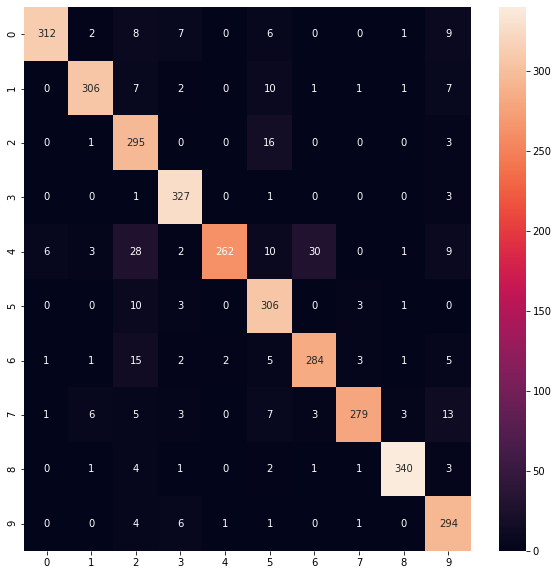

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm1 = confusion_matrix(test_label_names, mnb_predictions, labels=label_map_df['Label Name'].values)
plt.figure(figsize=(10,10))
sns.heatmap(cm1, annot=True, fmt='d')

# Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

lr_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('lr', LogisticRegression(penalty='l2', max_iter=100, random_state=42))
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'lr__C': [1, 5, 10]
}

gs_lr = RandomizedSearchCV(lr_pipeline, param_grid, cv=5, verbose=2,n_jobs=-1)
gs_lr = gs_lr.fit(train_corpus, train_label_names)

C:\Users\Thalut\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  1.6min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.3min finished


In [14]:
gs_lr.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(C=5, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,

In [20]:
lr = LogisticRegression(penalty='l2', max_iter=100, C=1, random_state=42)
lr.fit(tv_train_features, train_label_names)
best_lr_cv_scores = cross_val_score(lr, tv_train_features, train_label_names, cv=5)
best_lr_cv_mean_score = np.mean(best_lr_cv_scores)
print('Train Score (5-fold):', best_lr_cv_scores)
print('Average Train Score:', best_lr_cv_mean_score)

best_lr_test_score = gs_lr.score(test_corpus, test_label_names)
print('Test Accuracy :', best_lr_test_score)

Train Score (5-fold): [0.97761194 0.97910448 0.96641791 0.98283582 0.98059701]
Average Train Score: 0.9773134328358208
Test Accuracy : 0.9772727272727273


In [49]:
lr = LogisticRegression(penalty='l2', max_iter=100, C=1, random_state=42)
start = time.time()
lr.fit(train, train_label_names)
stop = time.time()
timelr= str(round(stop-start,3)) + 's'
print('Training time: ', timelr)

Training time:  36.588s


In [16]:
lr_predictions = lr.predict(tv_test_features)
unique_classes = list(set(test_label_names))
meu.get_metrics(true_labels=test_label_names, predicted_labels=lr_predictions)
meu.display_classification_report(true_labels=test_label_names, predicted_labels=lr_predictions, classes=unique_classes)

Accuracy: 0.9755
Precision: 0.9755
Recall: 0.9755
F1 Score: 0.9754
              precision    recall  f1-score   support

     thyroid       1.00      0.99      1.00       353
    prostate       0.98      0.99      0.99       332
     bladder       0.98      0.97      0.98       307
  oesophagus       0.96      0.96      0.96       319
        lung       0.99      0.99      0.99       345
cervix_uteri       0.97      0.97      0.97       320
      breast       0.99      1.00      0.99       335
     stomach       0.97      0.95      0.96       351
  colorectal       0.97      0.97      0.97       315
       liver       0.94      0.96      0.95       323

    accuracy                           0.98      3300
   macro avg       0.98      0.98      0.98      3300
weighted avg       0.98      0.98      0.98      3300



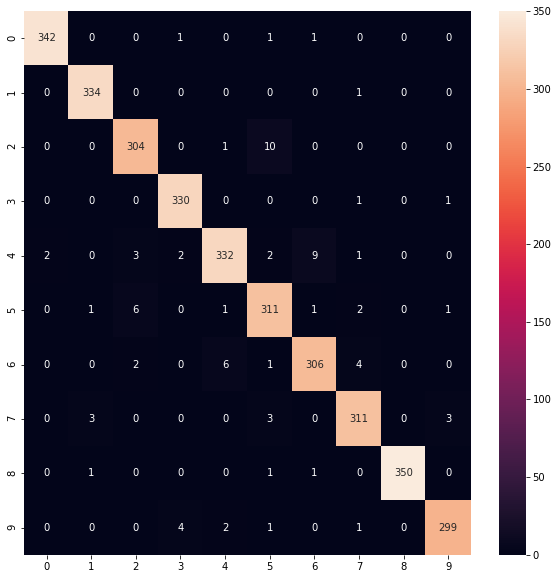

In [42]:
cm2 = confusion_matrix(test_label_names, lr_predictions, labels=label_map_df['Label Name'].values)
plt.figure(figsize=(10,10))
sns.heatmap(cm2, annot=True, fmt='d')

# Linier SVM

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

svm_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('svm', LinearSVC(random_state=42))
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'svm__C': [0.01, 0.1, 1, 5]
}

gs_svm = RandomizedSearchCV(svm_pipeline, param_grid, cv=5, verbose=2,n_jobs=-1)
gs_svm = gs_svm.fit(train_corpus, train_label_names)

C:\Users\Thalut\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:   13.0s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   19.1s finished


In [18]:
gs_svm.best_estimator_.get_params()

{'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.float64'>, encoding='utf-8',
                   input='content', lowercase=True, max_df=1.0, max_features=None,
                   min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                   smooth_idf=True, stop_words=None, strip_accents=None,
                   sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, use_idf=True, vocabulary=None)),
  ('svm',
   LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
             intercept_scaling=1, loss='squared_hinge', max_iter=1000,
             multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
             verbose=0))],
 'verbose': False,
 'tfidf': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                 dtype=<class 'numpy.float64'>, encoding='utf-8',
                 input='cont

In [21]:
svm = LinearSVC(penalty='l2', C=1, random_state=42)
svm.fit(tv_train_features, train_label_names)
best_svm_cv_scores = cross_val_score(svm, tv_train_features, train_label_names, cv=5)
best_svm_cv_mean_score = np.mean(best_svm_cv_scores)
print('Train Score (5-fold):', best_svm_cv_scores)
print('Average Train Score:', best_svm_cv_mean_score)

best_svm_test_score = gs_svm.score(test_corpus, test_label_names)
print('Test Accuracy :', best_svm_test_score)

Train Score (5-fold): [0.97910448 0.97761194 0.97014925 0.98656716 0.97835821]
Average Train Score: 0.9783582089552239
Test Accuracy : 0.9784848484848485


In [50]:
svm = LinearSVC(penalty='l2', C=1, random_state=42)
start = time.time()
svm.fit(train, train_label_names)
stop = time.time()
timesvm= str(round(stop-start,3)) + 's'
print('Training time: ', timesvm)

Training time:  1.389s


In [22]:
svm_predictions = svm.predict(tv_test_features)
unique_classes = list(set(test_label_names))
meu.get_metrics(true_labels=test_label_names, predicted_labels=svm_predictions)
meu.display_classification_report(true_labels=test_label_names, predicted_labels=svm_predictions, classes=unique_classes)

Accuracy: 0.9752
Precision: 0.9753
Recall: 0.9752
F1 Score: 0.9751
              precision    recall  f1-score   support

     thyroid       0.99      1.00      1.00       353
    prostate       0.98      1.00      0.99       332
     bladder       0.99      0.97      0.98       307
  oesophagus       0.96      0.96      0.96       319
        lung       0.99      0.99      0.99       345
cervix_uteri       0.97      0.95      0.96       320
      breast       0.99      0.99      0.99       335
     stomach       0.97      0.94      0.96       351
  colorectal       0.97      0.97      0.97       315
       liver       0.94      0.98      0.96       323

    accuracy                           0.98      3300
   macro avg       0.97      0.97      0.97      3300
weighted avg       0.98      0.98      0.98      3300



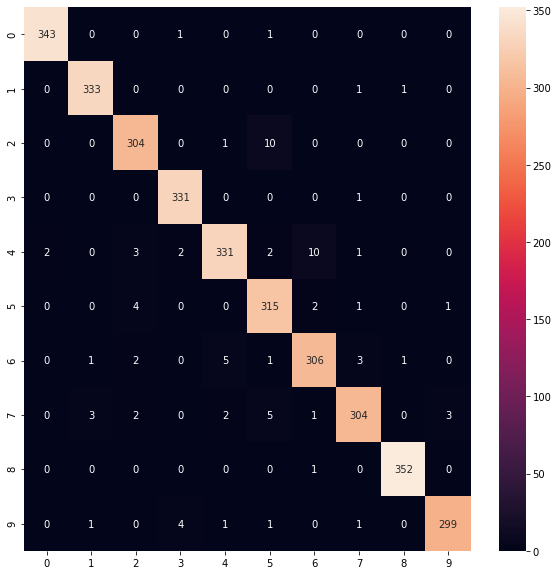

In [43]:
cm3 = confusion_matrix(test_label_names, svm_predictions, labels=label_map_df['Label Name'].values)
plt.figure(figsize=(10,10))
sns.heatmap(cm3, annot=True, fmt='d')

# Linier SVM(SGD)

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

sgd_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('sgd', SGDClassifier(random_state=42))
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'sgd__alpha': [1e-7, 1e-6, 1e-5, 1e-4]
}

gs_sgd = RandomizedSearchCV(sgd_pipeline, param_grid, cv=5, verbose=2,n_jobs=-1)
gs_sgd = gs_sgd.fit(train_corpus, train_label_names)

C:\Users\Thalut\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    7.9s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   11.0s finished


In [24]:
gs_sgd.best_estimator_.get_params()

{'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.float64'>, encoding='utf-8',
                   input='content', lowercase=True, max_df=1.0, max_features=None,
                   min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                   smooth_idf=True, stop_words=None, strip_accents=None,
                   sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, use_idf=True, vocabulary=None)),
  ('sgd',
   SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                 early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
                 l1_ratio=0.15, learning_rate='optimal', loss='hinge',
                 max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
                 power_t=0.5, random_state=42, shuffle=True, tol=0.001,
                 validation_fraction=0.1, verbose=0, warm_start=F

In [25]:
svm_sgd = SGDClassifier(loss='hinge', penalty='l2', max_iter=5, random_state=42)
svm_sgd.fit(tv_train_features, train_label_names)
best_sgd_cv_scores = cross_val_score(svm_sgd, tv_train_features, train_label_names, cv=5)
best_sgd_cv_mean_score = np.mean(best_sgd_cv_scores)
print('Train Score (5-fold):', best_sgd_cv_scores)
print('Average Train Score :', best_sgd_cv_mean_score)

best_sgd_test_score = gs_sgd.score(test_corpus, test_label_names)
print('Test Accuracy :', best_sgd_test_score)

C:\Users\Thalut\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Thalut\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Train Score (5-fold): [0.97985075 0.97537313 0.96865672 0.98507463 0.97835821]
Average Train Score : 0.9774626865671643
Test Accuracy : 0.9769696969696969


In [51]:
svm_sgd = SGDClassifier(loss='hinge', penalty='l2', max_iter=5, random_state=42)
start = time.time()
svm_sgd.fit(train, train_label_names)
stop = time.time()
timesvm_sgd = str(round(stop-start,3)) + 's'
print('Training time: ', timesvm_sgd)

Training time:  0.315s


C:\Users\Thalut\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [26]:
svm_sgd_predictions = svm_sgd.predict(tv_test_features)
unique_classes = list(set(test_label_names))
meu.get_metrics(true_labels=test_label_names, predicted_labels=svm_sgd_predictions)
meu.display_classification_report(true_labels=test_label_names, predicted_labels=svm_sgd_predictions, classes=unique_classes)

Accuracy: 0.9736
Precision: 0.9738
Recall: 0.9736
F1 Score: 0.9736
              precision    recall  f1-score   support

     thyroid       0.99      1.00      1.00       353
    prostate       0.98      1.00      0.99       332
     bladder       0.99      0.97      0.98       307
  oesophagus       0.94      0.96      0.95       319
        lung       0.99      1.00      1.00       345
cervix_uteri       0.98      0.95      0.96       320
      breast       0.98      0.99      0.99       335
     stomach       0.98      0.93      0.96       351
  colorectal       0.96      0.96      0.96       315
       liver       0.94      0.97      0.96       323

    accuracy                           0.97      3300
   macro avg       0.97      0.97      0.97      3300
weighted avg       0.97      0.97      0.97      3300



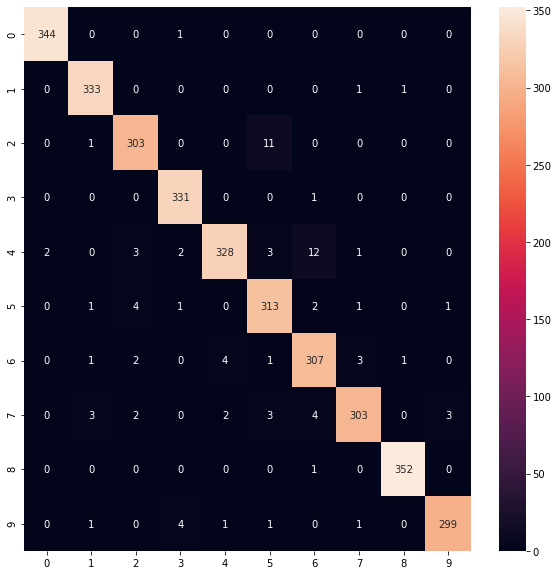

In [44]:
cm4 = confusion_matrix(test_label_names, svm_sgd_predictions, labels=label_map_df['Label Name'].values)
plt.figure(figsize=(10,10))
sns.heatmap(cm4, annot=True, fmt='d')

# Random Forest

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('rf', RandomForestClassifier(random_state=42))
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'rf__max_depth': [80, 90, 100, 110],
              'rf__n_estimators': [10, 20, 50, 100]
#               'rf__min_samples_leaf': [3, 4, 5],
#               'rf__min_samples_split': [8, 10, 12],
              
              
              
}

gs_rf = RandomizedSearchCV(rf_pipeline, param_grid, cv=5, verbose=2, n_jobs=-1)
gs_rf = gs_rf.fit(train_corpus, train_label_names)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:   54.0s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   57.2s finished


In [28]:
gs_rf.best_estimator_.get_params()

{'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.float64'>, encoding='utf-8',
                   input='content', lowercase=True, max_df=1.0, max_features=None,
                   min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                   smooth_idf=True, stop_words=None, strip_accents=None,
                   sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, use_idf=True, vocabulary=None)),
  ('rf',
   RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                          criterion='gini', max_depth=100, max_features='auto',
                          max_leaf_nodes=None, max_samples=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=

In [32]:
rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rfc.fit(tv_train_features, train_label_names)
best_gs_rf_cv_scores = cross_val_score(rfc, tv_train_features, train_label_names, cv=5)
best_gs_rf_cv_mean_score = np.mean(best_gs_rf_cv_scores)
print('Train Score (5-fold):', best_gs_rf_cv_scores)
print('Average Train Score :', best_gs_rf_cv_mean_score)

best_gs_rf_test_score = gs_rf.score(test_corpus, test_label_names)
print('Test Accuracy :', best_gs_rf_test_score)

Train Score (5-fold): [0.88507463 0.88283582 0.90447761 0.89477612 0.90746269]
Average Train Score : 0.8949253731343283
Test Accuracy : 0.9733333333333334


In [52]:
rfc = RandomForestClassifier(n_estimators=10, random_state=42)
start = time.time()
rfc.fit(train, train_label_names)
stop = time.time()
timerfc = str(round(stop-start,3)) + 's'
print('Training time: ', timerfc)

Training time:  7.53s


In [30]:
rfc_predictions = rfc.predict(tv_test_features)
unique_classes = list(set(test_label_names))
meu.get_metrics(true_labels=test_label_names, predicted_labels=rfc_predictions)
meu.display_classification_report(true_labels=test_label_names, predicted_labels=rfc_predictions, classes=unique_classes)

Accuracy: 0.9103
Precision: 0.9122
Recall: 0.9103
F1 Score: 0.9105
              precision    recall  f1-score   support

     thyroid       0.96      0.92      0.94       353
    prostate       0.94      0.93      0.94       332
     bladder       0.86      0.94      0.90       307
  oesophagus       0.93      0.88      0.90       319
        lung       0.95      0.90      0.93       345
cervix_uteri       0.91      0.89      0.90       320
      breast       0.93      0.98      0.95       335
     stomach       0.93      0.86      0.89       351
  colorectal       0.86      0.91      0.89       315
       liver       0.83      0.89      0.86       323

    accuracy                           0.91      3300
   macro avg       0.91      0.91      0.91      3300
weighted avg       0.91      0.91      0.91      3300



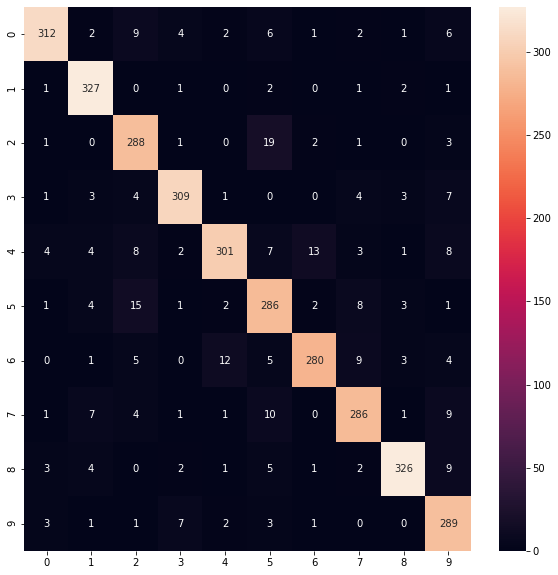

In [45]:
cm5 = confusion_matrix(test_label_names, rfc_predictions, labels=label_map_df['Label Name'].values)
plt.figure(figsize=(10,10))
sns.heatmap(cm5, annot=True, fmt='d')

# Gradient Boosting Machine

In [31]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

gbm_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                        ('gbm', GradientBoostingClassifier(random_state=42))
                       ])

param_grid = {'tfidf__ngram_range': [(1, 1), (1, 2)],
              'gbm__min_samples_split': [2, 3],
              'gbm__max_depth': [3, 4],
}

gbm_rf = RandomizedSearchCV(gbm_pipeline, param_grid, cv=5, verbose=2, n_jobs=-1)
gbm_rf = gbm_rf.fit(train_corpus, train_label_names)

C:\Users\Thalut\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed: 17.4min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 29.0min finished


In [33]:
gbm_rf.best_estimator_.get_params()

{'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.float64'>, encoding='utf-8',
                   input='content', lowercase=True, max_df=1.0, max_features=None,
                   min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                   smooth_idf=True, stop_words=None, strip_accents=None,
                   sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=None, use_idf=True, vocabulary=None)),
  ('gbm',
   GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                              learning_rate=0.1, loss='deviance', max_depth=3,
                              max_features=None, max_leaf_nodes=None,
                              min_impurity_decrease=0.0, min_impurity_split=None,
                              min_samples_leaf=1, min_samples_split=2,
                              min_weight_fraction_

In [34]:
gbc = GradientBoostingClassifier(n_estimators=10, random_state=42)
gbc.fit(tv_train_features, train_label_names)
best_gbm_rf_cv_scores = cross_val_score(gbc, tv_train_features, train_label_names, cv=5)
best_gbm_rf_cv_mean_score = np.mean(best_gbm_rf_cv_scores)
print('Train Score (5-fold):', best_gbm_rf_cv_scores)
print('Average Train Score :', best_gbm_rf_cv_mean_score)

best_gbm_rf_test_score = gbm_rf.score(test_corpus, test_label_names)
print('Test Accuracy :', best_gbm_rf_test_score)

Train Score (5-fold): [0.97089552 0.9619403  0.96492537 0.97537313 0.96567164]
Average Train Score : 0.9677611940298508
Test Accuracy : 0.9721212121212122


In [53]:
gbc = GradientBoostingClassifier(n_estimators=10, random_state=42)
start = time.time()
gbc.fit(train, train_label_names)
stop = time.time()
timegbc = str(round(stop-start,3)) + 's'
print('Training time: ', timegbc)

Training time:  61.03s


In [35]:
gbc_predictions = gbc.predict(tv_test_features)
unique_classes = list(set(test_label_names))
meu.get_metrics(true_labels=test_label_names, predicted_labels=gbc_predictions)
meu.display_classification_report(true_labels=test_label_names, predicted_labels=gbc_predictions, classes=unique_classes)

Accuracy: 0.967
Precision: 0.9685
Recall: 0.967
F1 Score: 0.9672
              precision    recall  f1-score   support

     thyroid       0.99      1.00      0.99       353
    prostate       0.97      1.00      0.99       332
     bladder       0.99      0.96      0.98       307
  oesophagus       0.96      0.92      0.94       319
        lung       1.00      0.98      0.99       345
cervix_uteri       0.87      0.99      0.93       320
      breast       1.00      0.99      0.99       335
     stomach       0.98      0.94      0.96       351
  colorectal       0.98      0.93      0.95       315
       liver       0.93      0.95      0.94       323

    accuracy                           0.97      3300
   macro avg       0.97      0.97      0.97      3300
weighted avg       0.97      0.97      0.97      3300



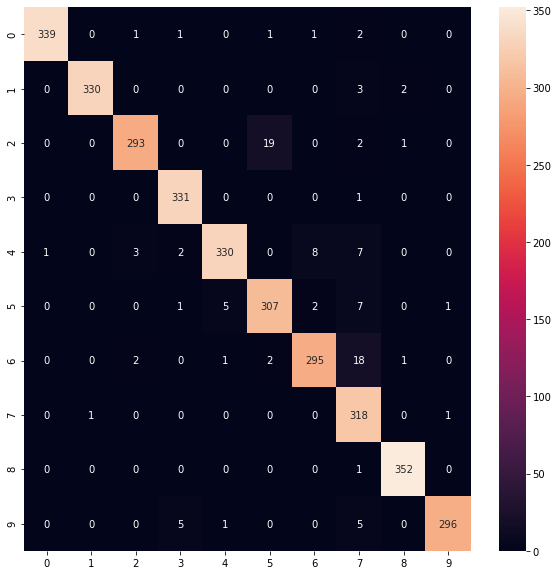

In [46]:
cm6 = confusion_matrix(test_label_names, gbc_predictions, labels=label_map_df['Label Name'].values)
plt.figure(figsize=(10,10))
sns.heatmap(cm6, annot=True, fmt='d')

In [56]:
finaldf = pd.DataFrame([['Naive Bayes', timemnb, gs_mnb_cv_mean_score, best_mnb_test_score],
              ['Logistic Regression', timelr, best_lr_cv_mean_score, best_lr_test_score],
              ['Linear SVM', timesvm, best_svm_cv_mean_score, best_svm_test_score],
              ['Linear SVM (SGD)',  timesvm_sgd, best_sgd_cv_mean_score, best_sgd_test_score],
              ['Random Forest', timerfc, best_gs_rf_cv_mean_score, best_gs_rf_test_score],
              ['Gradient Boosted Machines', timegbc, best_gbm_rf_cv_mean_score, best_gbm_rf_test_score]],
             columns=['Model',  'Training Time(s)', 'Train Score', 'Test Score (TFIDF)'],
             )
finaldf

,Model,Training Time(s),Train Score,Test Score (TFIDF)
0,Naive Bayes,0.14s,0.922537,0.951818
1,Logistic Regression,36.588s,0.977313,0.977273
2,Linear SVM,1.389s,0.978358,0.978485
3,Linear SVM (SGD),0.315s,0.977463,0.976970
4,Random Forest,7.53s,0.894925,0.973333
5,Gradient Boosted Machines,61.03s,0.967761,0.972121


In [57]:
finaldf.to_csv (r'C:\Users\Thalut\Exchange\Midterm Text Mining\Output\save114.csv', index = False, header=True)

In [47]:
model_name = ['Naive Bayes', 'Linier Regression', 'SVM', 'SVM(SGD)', 'Random Forest', 'Gradient Boost Machine']
model_var = [mnb, lr, svm, svm_sgd, rfc, gbc]
for i in range(len(model_name)):
    x_predictions = model_var[i].predict(tv_test_features)
    unique_classes = list(set(test_label_names))
    print(model_name[i])
    meu.get_metrics(true_labels=test_label_names, predicted_labels=x_predictions)
    print()

Naive Bayes
Accuracy: 0.9106
Precision: 0.9179
Recall: 0.9106
F1 Score: 0.9107

Linier Regression
Accuracy: 0.9755
Precision: 0.9755
Recall: 0.9755
F1 Score: 0.9754

SVM
Accuracy: 0.9752
Precision: 0.9753
Recall: 0.9752
F1 Score: 0.9751

SVM(SGD)
Accuracy: 0.9736
Precision: 0.9738
Recall: 0.9736
F1 Score: 0.9736

Random Forest
Accuracy: 0.9103
Precision: 0.9122
Recall: 0.9103
F1 Score: 0.9105

Gradient Boost Machine
Accuracy: 0.967
Precision: 0.9685
Recall: 0.967
F1 Score: 0.9672

